# Multiple Linear Regression
## Shared Bikes Demand Prediction - Assignment Solution

#### Problem Statement:

A US bike-sharing provider `BoomBikes` has a daily dataset on the rental bikes based on various environmental and seasonal settings. It wishes to use this data to understand the factors affecting the demand for these shared bikes in the American market and come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown due to corona pandemic comes to an end.

Essentially, the company wants to know —


- Which variables are significant in predicting the demand for shared bikes.


- How well those variables describe the bike demands


**So interpretation is important!**

In [1]:
# Importing all the necessary libraries

import pandas as pd, numpy as np
import matplotlib.pyplot as plt,seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import calendar

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import pearsonr

## 1) Data Understanding, Cleaning and Exploration

In [2]:
df = pd.read_csv("day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Sanity Checks

In [3]:
df.shape

(730, 16)

In [4]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

From df.describe() and df.info() we can conclude that,
- The data does not contain any null values, missing values or duplicate values.
- All the variables seems to be in valid range, we will use box plot to verify the same.

In [8]:
# numerical columns
num_cols = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

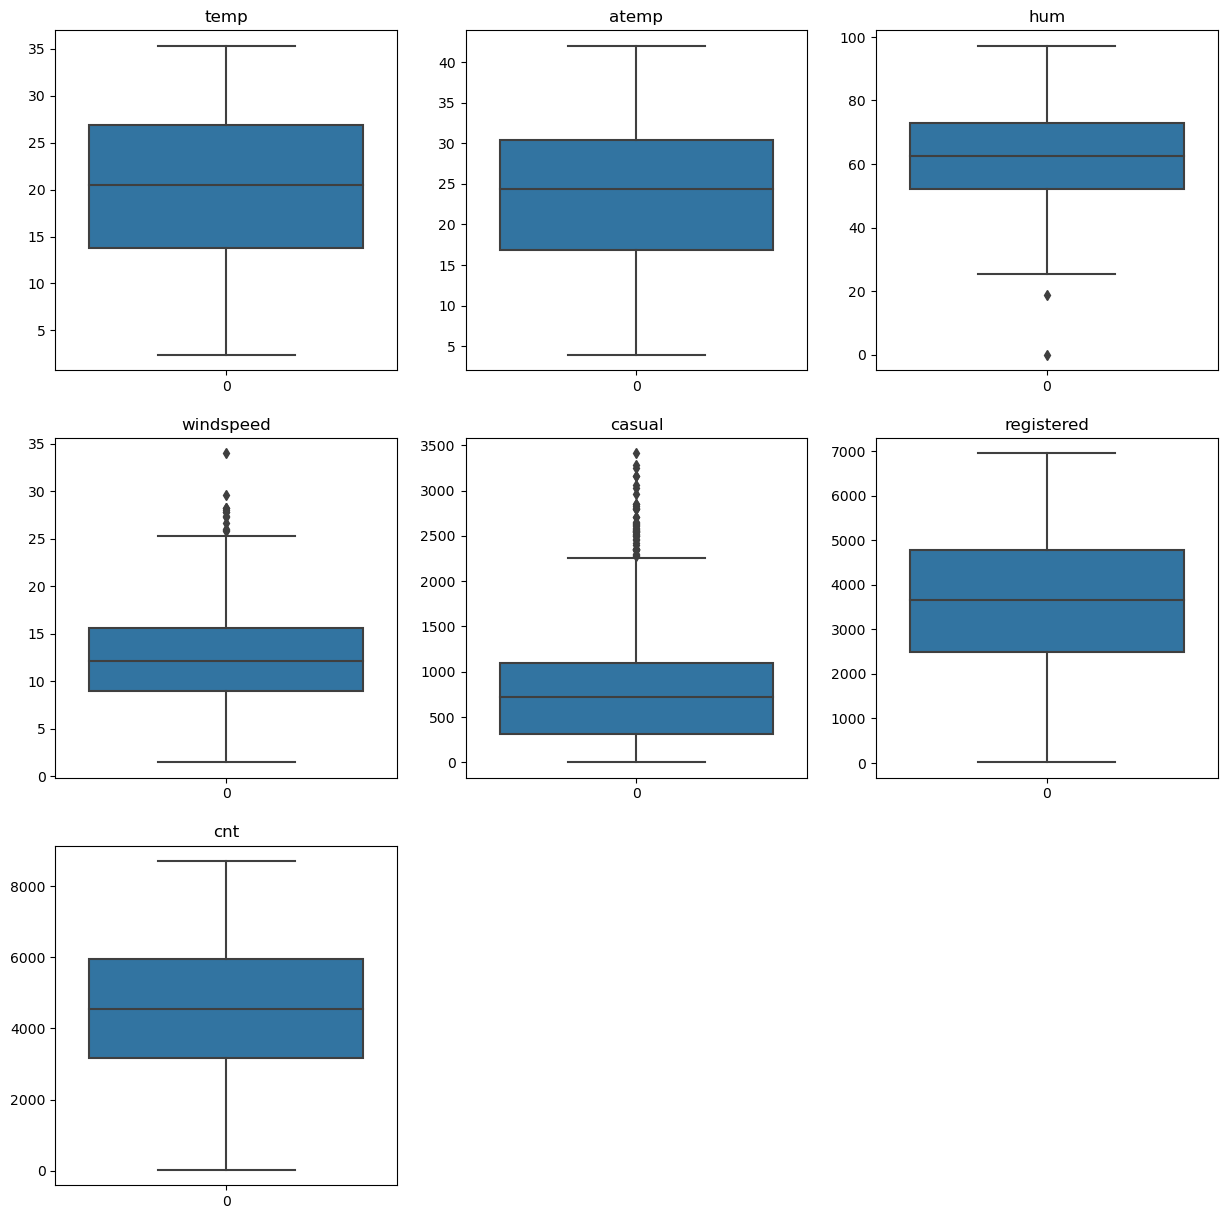

In [9]:
# outliers detection

plt.figure(figsize=(15,15))
for i,j in enumerate(num_cols,1):
    plt.subplot(3,3,i)
    sns.boxplot(df[j])
    plt.title(j)
    plt.xlabel(None)
plt.show()

Note: 
we can observe that windspeed and casual variables have outliers present but these are real possible values, but humidity seems to be zero at a point, so lets further investigate humidity column.

In [10]:
df.hum.sort_values().head()

68      0.0000
49     18.7917
461    25.4167
462    27.5833
450    29.0000
Name: hum, dtype: float64

As we can see that humidity is zero which is not a practicle value, we will impute the value with median

In [11]:
df.hum.loc[68] = df.hum.median()

## Identifyting unnecessary columns
- As we already have index starting from "0", we will drop instant column as it is present in the dataset for the same purpose as index.
- We also have year and month as seperate column, as these columns would be sufficient for our analysis and model building, we will drop the dteday column too
- We will keep on adding unnecessary columns to below list as we move forward.

In [12]:
unnecessarys_cols = ["instant","dteday"]

## Data Transformation

- There are few columns which are categorical, like (season,yr,mnth,holiday,weekday,workingday,weathersit)
- data in some of them is already in desired format, lets convert the data type of these columns to categorical.

In [13]:
categorical_cols = ["season","yr","mnth","holiday","weekday","workingday","weathersit"]

In [14]:
req_categorical_cols = ["season","mnth","weekday","weathersit"] 
# yr,holiday,workingday are already in required binary format

Lets change the categorical column's datatype to category format and map appropriate categories.

In [15]:
df[req_categorical_cols] = df[req_categorical_cols].astype("category")

In [16]:
df["season"] = df["season"].map({1:"spring", 2:"summer", 3:"fall", 4:"winter"})

month_dict = dict(enumerate(calendar.month_abbr))  # {1-jan, 2- feb...  12- dec} 
df["mnth"] = df["mnth"].map(month_dict)

df.weekday = df.weekday.map({1:"Monday",2:"Tuesday",3:"Wednesday",4:"Thursday",5:"Friday",6:"Saturday",0:"Sunday"})

df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,Jan,0,Monday,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,Jan,0,Tuesday,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,Jan,0,Wednesday,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,Jan,0,Thursday,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,Jan,0,Friday,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


##### As numbers in weather column provides information about various weather situations, we will keep them as it is.
weather column details
- 1: "Clear, Few clouds, Partly cloudy"
- 2: "Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist"
- 3: "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds"
- 4: "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog"

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   instant     730 non-null    int64   
 1   dteday      730 non-null    object  
 2   season      730 non-null    category
 3   yr          730 non-null    int64   
 4   mnth        730 non-null    category
 5   holiday     730 non-null    int64   
 6   weekday     730 non-null    category
 7   workingday  730 non-null    int64   
 8   weathersit  730 non-null    category
 9   temp        730 non-null    float64 
 10  atemp       730 non-null    float64 
 11  hum         730 non-null    float64 
 12  windspeed   730 non-null    float64 
 13  casual      730 non-null    int64   
 14  registered  730 non-null    int64   
 15  cnt         730 non-null    int64   
dtypes: category(4), float64(4), int64(7), object(1)
memory usage: 72.5+ KB


## 2) Data Analysis and Visualisation

### 2.1 Numerical Data

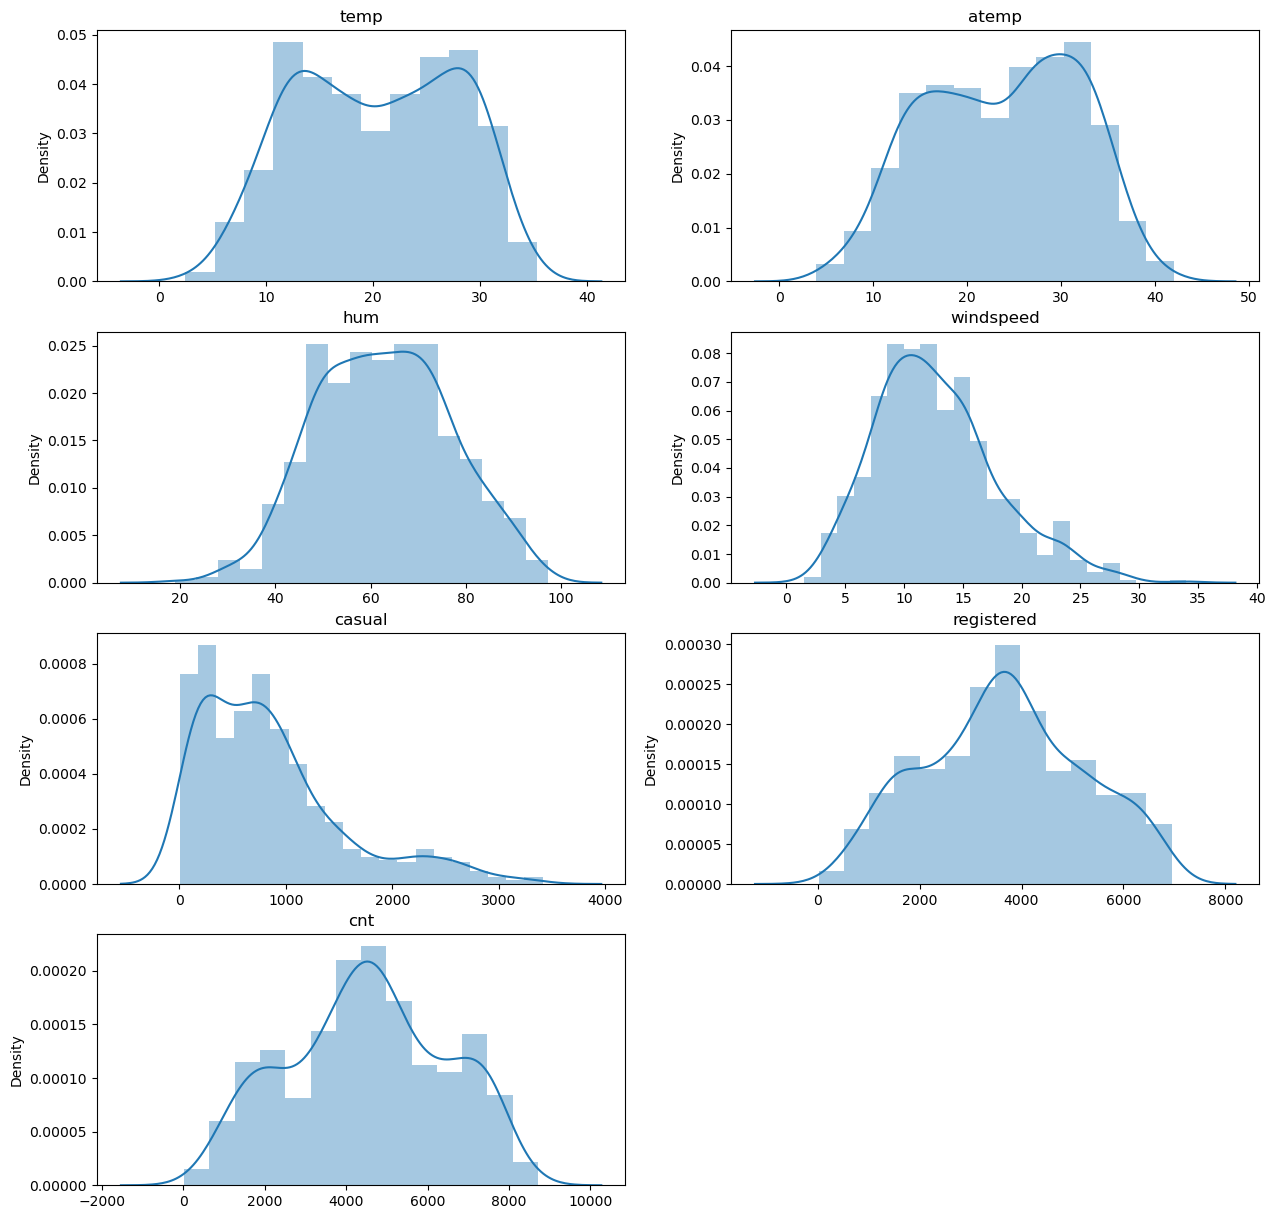

In [18]:
# Distribution of numerical variables

plt.figure(figsize=(15,15))

for i,j in enumerate(num_cols,1):
    plt.subplot(4,2,i)
    sns.distplot(df[j])
    plt.title(j)
    plt.xlabel(None)
plt.show()

- 'temp'-'atemp'
- 'registered'-'cnt'

Above variables are showing almost similar distribution which is a strong indicator of multi-collinearity, we will deal with these variables before model building

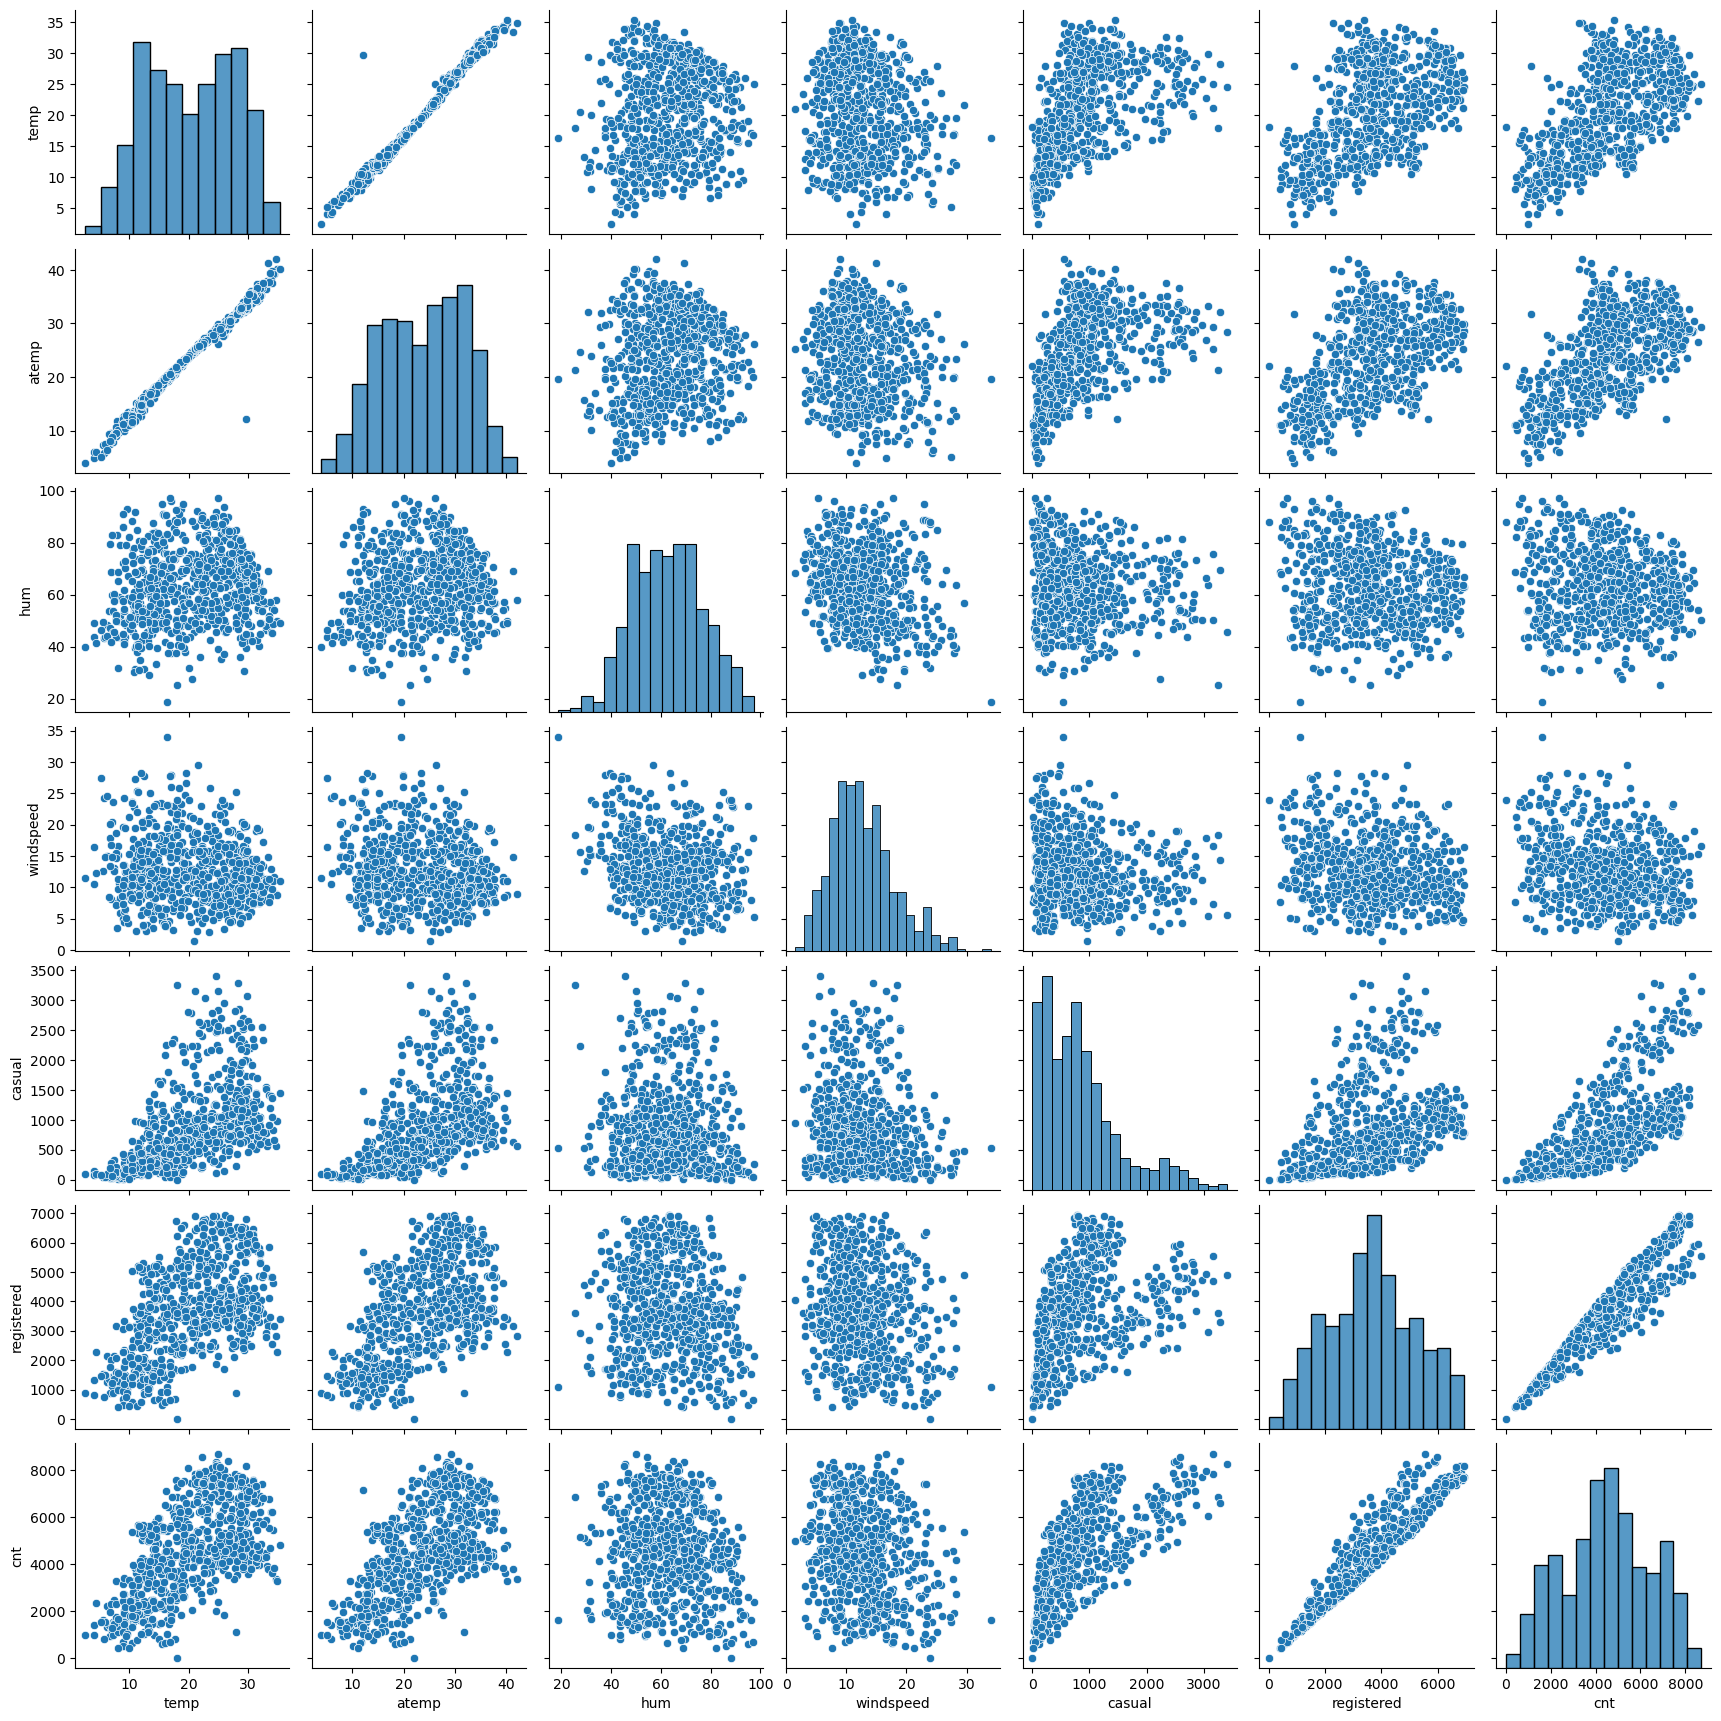

In [19]:
# pair plot of numerical columns
sns.pairplot(df[num_cols]) 
plt.show()

- We can observe that some of the numerical variables have linear relationship with the target variable. eg, temp, atemp, registered, casual.
- We can verify the first assumption of Linear regression which is X and y have linear relation. Atleast few numerical variables should follow linear relation to proceed with the linear regression model.

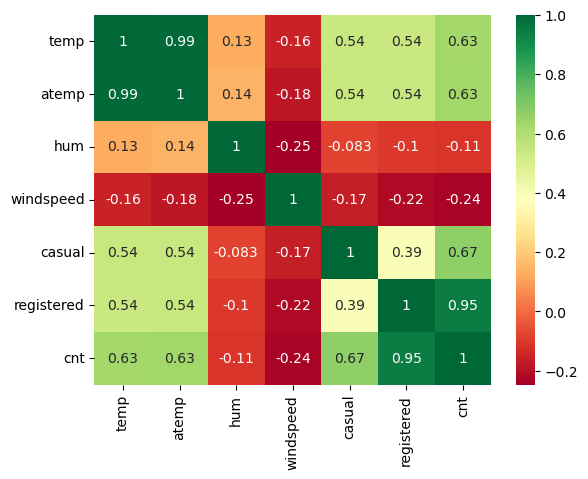

In [20]:
# checking the strenght of correlation
sns.heatmap(df[num_cols].corr(),cmap="RdYlGn",annot=True)
plt.show()

- From pair plots & heatmap, it can be observed that some of the variables are highly correlated, i.e. cnt and registered, temp and a temp.
- lets check further by plotting detailed graph of these variables.

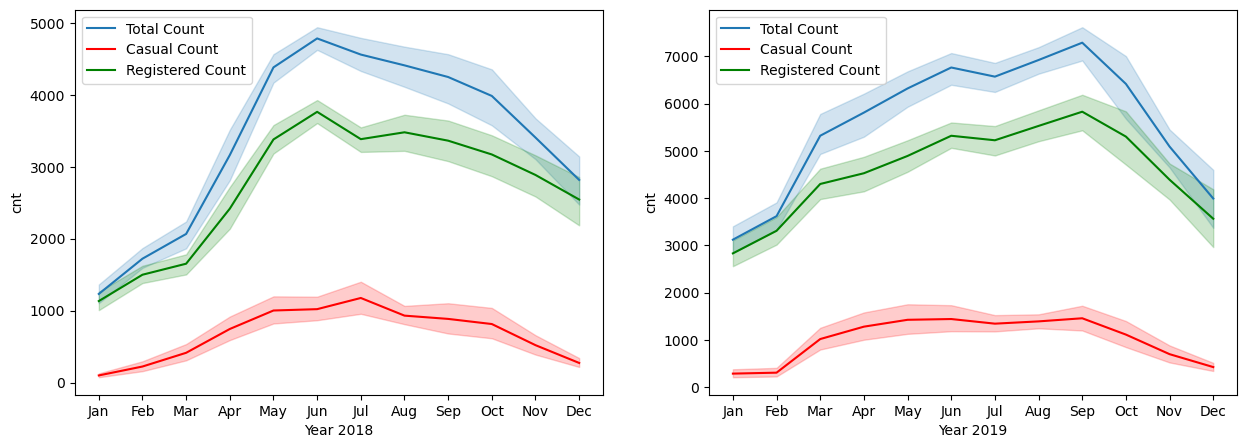

In [21]:
# cnt and registered

plt.figure(figsize=(15,5))
for i in range(0,2):
    plt.subplot(1,2,i+1)
    sns.lineplot(data=df[df.yr==i],x="mnth",y="cnt",label="Total Count")
    sns.lineplot(data=df[df.yr==i],x="mnth",y="casual",color="red",label = "Casual Count" )
    sns.lineplot(data=df[df.yr==i],x="mnth",y="registered",color="green",label = "Registered Count")
    lb = "Year"+" "+str(2018+i)
    plt.xlabel(lb)
plt.show()

- Most of the revenue is generated from the registered users, that's why the monthwise variation in the count of total members and registered members is almost similar. 
- we can also say that registered members are major contributors to our business revenue.

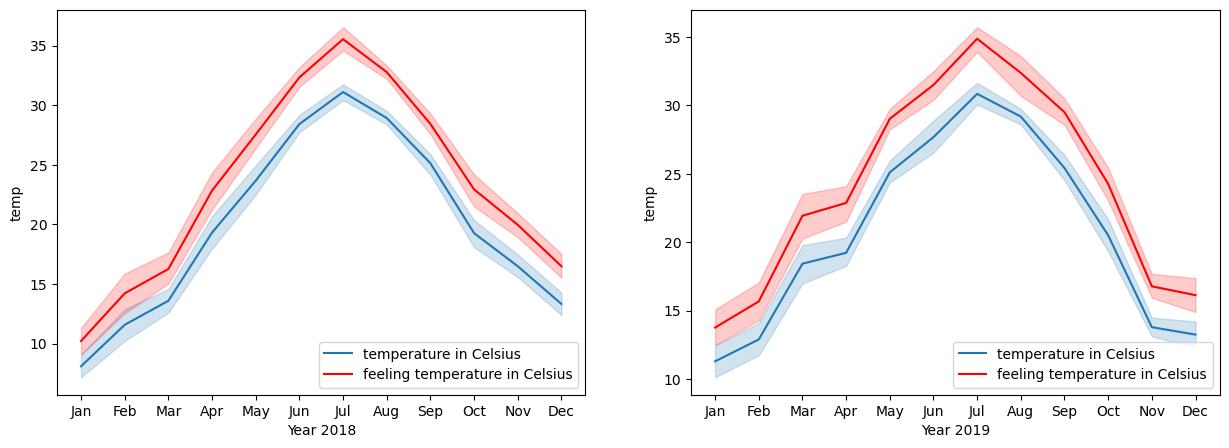

In [22]:
# temp and atemp

plt.figure(figsize=(15,5))
for i in range(0,2):
    plt.subplot(1,2,i+1)
    sns.lineplot(data=df[df.yr==i],x="mnth",y="temp",label="temperature in Celsius")
    sns.lineplot(data=df[df.yr==i],x="mnth",y="atemp",color="red",label = "feeling temperature in Celsius" )
    lb = "Year"+" "+str(2018+i)
    plt.xlabel(lb)
plt.show()

- we can conclude that below variables are highly correlated with each other
    - registered and cnt
    - temp and atemp
- Due to temp and atemp variables, we are most likely to encounter multicollinearity while model building. As both of the variables point out temperature only, we can drop atemp variable as well as "registered" variable.
- Also its better to drop "casual" variable too because we are not going to focus on categorywise count.

### Dropping unnecessary columns

In [23]:
unnecessarys_cols.extend(["atemp","registered","casual"])

In [24]:
df.drop(unnecessarys_cols,axis=1,inplace=True)

### 2.2 Categorical data

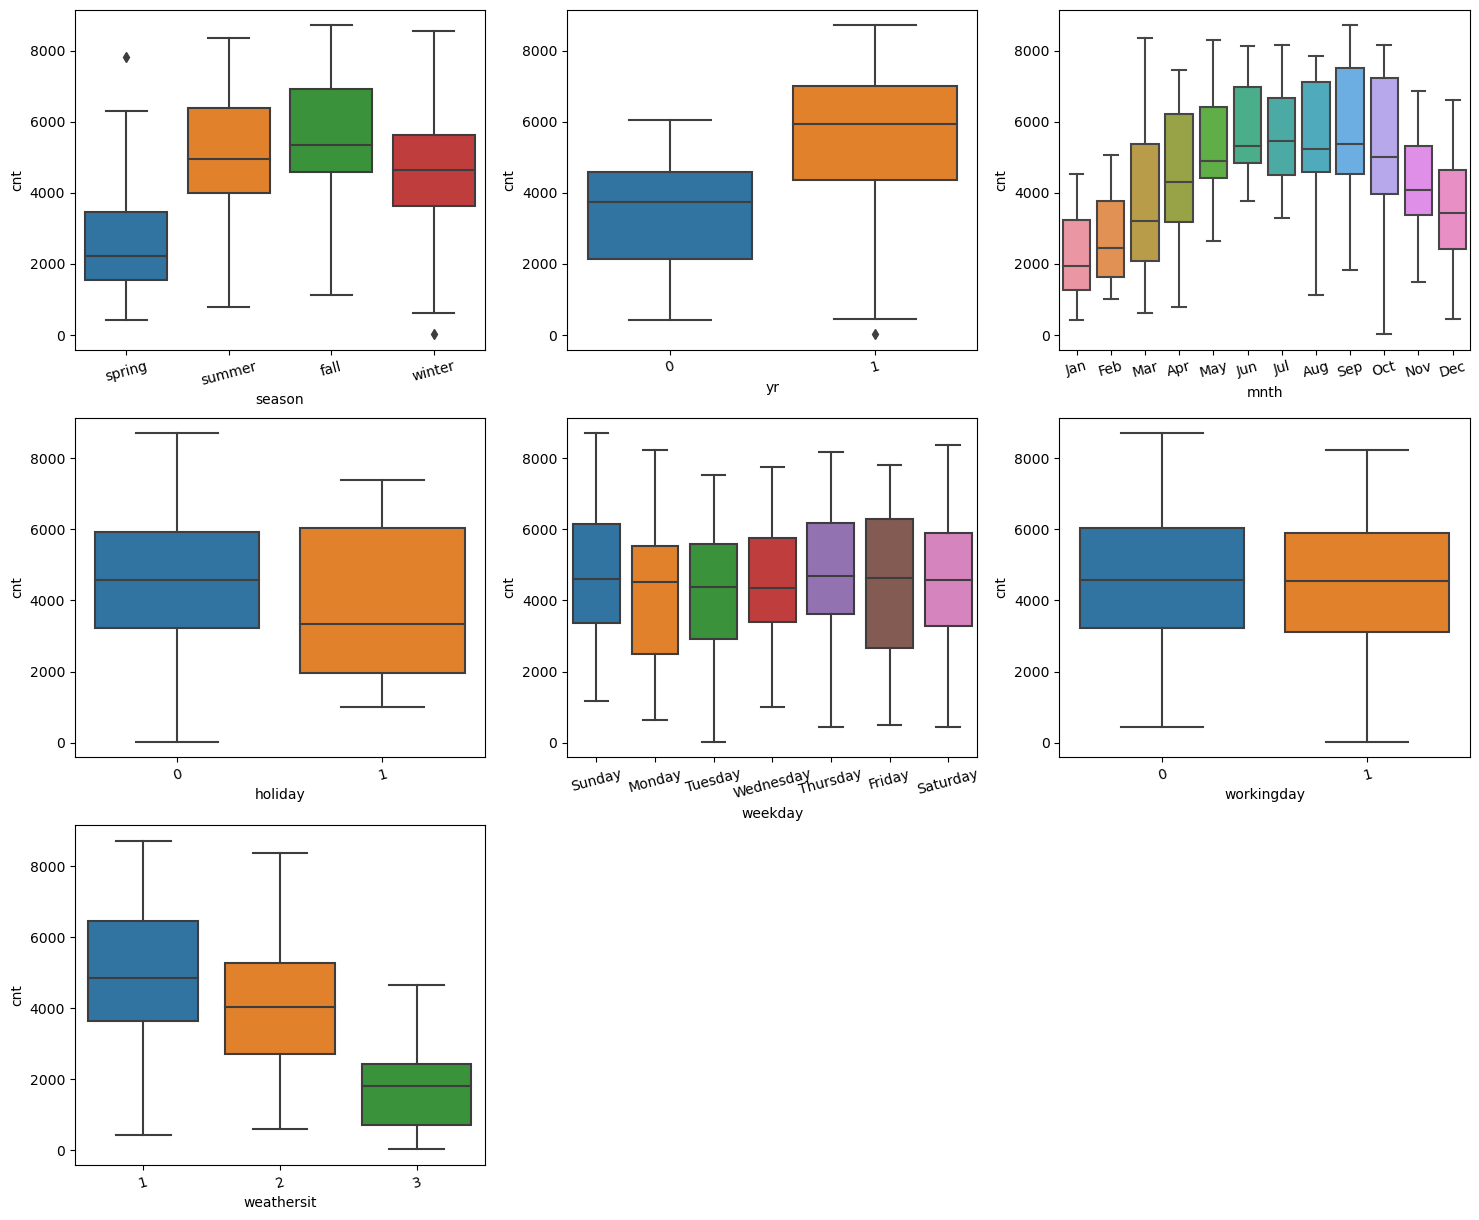

In [25]:
# plotting box plots
plt.figure(figsize=(18,15))
for i,j in enumerate(categorical_cols,1):
    plt.subplot(3,3,i)
    sns.boxplot(x=j,y="cnt",data=df)
    plt.xticks(rotation=15)
plt.show()

Notes:
- 1) As we had previously seen that number of rides increases from may to oct which corresponds to summer & fall season.
- 2) There is a significant increase in median number of rides from 2018 to 2019 (approx 50%, went from approx 4000 to approx 6000), this shows a good upward trend.
- 3) Day of the week has almost no impact on median number of rides. we will see what the model decides about weekdays variable.
- 4) It does not matter if its working day or not(weekend or holiday), the median number of rides is almost similar in both the cases, this might be caused by the fact that most of the users belong to "registered" category who are regular users,
- 5) weather situation 1, which is Clear, Few clouds, Partly cloudy is most favourable for our business.
- 6) From the "Mnth", we can see that the months are following a trend and could be a good predictor variable. The bookings in the mid-month are above 4000. The count is highest in the month of Sept
- 7) Also, there seems to be outliers present in season and year column, next we will check the outliers

In [26]:
#  checking outliers

print(df[df.season=="spring"].cnt.max())
print(df[df.season=="winter"].cnt.min())
print(df[df.yr==1].cnt.min())

7836
22
22


As all the above values seems legitimate, we cannot drop these values.

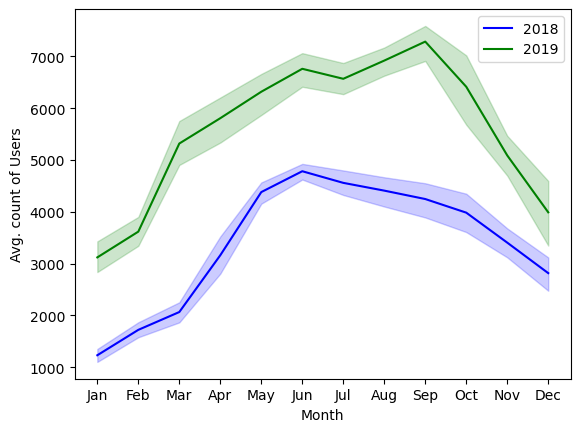

In [27]:
# Month Vs Count
sns.lineplot(data=df[df.yr==0],x="mnth",y="cnt",color = "blue",label= "2018")
sns.lineplot(data=df[df.yr==1],x="mnth",y="cnt",color = "green",label= "2019")
plt.xlabel("Month")
plt.ylabel("Avg. count of Users")
plt.show()

Note: 
- we can see that the average number of users follows roughly similar trend in first half of the year, then gradually decreases. 
- by observing trend, we can say that the month 6 to 9 are our peak business months. Later on in model building, we will check which months are significant in order to capitalize this info to formulate some business strategy.

## 3. Data Preparation

#### One Hot Encoding Method

In [28]:
df1 = pd.get_dummies(df, drop_first=True)    # Creating dummy columns for categorical variables
df1.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,...,mnth_Nov,mnth_Dec,weekday_Monday,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,weekday_Saturday,weathersit_2,weathersit_3
0,0,0,1,14.110847,80.5833,10.749882,985,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,1,14.902598,69.6087,16.652113,801,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,1,8.050924,43.7273,16.636703,1349,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,0,0,0,...,0,0,0,0,0,0,1,0,0,0


let's split the data into train and test

In [29]:
df_train,df_test = train_test_split(df1,train_size=0.7,random_state=100)

In [30]:
print(df_train.shape)
print(df_test.shape)

(510, 29)
(220, 29)


In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 576 to 520
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   yr                 510 non-null    int64  
 1   holiday            510 non-null    int64  
 2   workingday         510 non-null    int64  
 3   temp               510 non-null    float64
 4   hum                510 non-null    float64
 5   windspeed          510 non-null    float64
 6   cnt                510 non-null    int64  
 7   season_summer      510 non-null    uint8  
 8   season_fall        510 non-null    uint8  
 9   season_winter      510 non-null    uint8  
 10  mnth_Feb           510 non-null    uint8  
 11  mnth_Mar           510 non-null    uint8  
 12  mnth_Apr           510 non-null    uint8  
 13  mnth_May           510 non-null    uint8  
 14  mnth_Jun           510 non-null    uint8  
 15  mnth_Jul           510 non-null    uint8  
 16  mnth_Aug           510 n

Firstly lets normalise the numerical variables using minmax scaling.

In [32]:
num_cols = ['temp', 'hum', 'windspeed', 'cnt']    # numerical columns
scalar = MinMaxScaler()                           # defining object

df_train[num_cols] = scalar.fit_transform(df_train[num_cols])      # scaling the numerical columns

In [33]:
df_train[num_cols].describe()     # checking if scaling is performed properly

,temp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000
mean,0.537440,0.568113,0.320883,0.513499
std,0.225858,0.177295,0.169803,0.224421
min,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.428913,0.199179,0.356420
50%,0.542596,0.570553,0.296763,0.518638
75%,0.735215,0.695953,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000


we can see that the normalisation has been done correctly, let's split the train dataset into predictor variables and target variable.

In [34]:
y_train = df_train.pop("cnt")              # y_train as target column
X_train = df_train                         # X-train as predictors i.e, all remaining columns

## 4. Model Building using Statsmodels

#### Let's first build a model with all the variables

### Model-0

In [35]:
X_train_sm = sm.add_constant(X_train) # adding constant

In [36]:
lm0_model = sm.OLS(y_train,X_train_sm).fit()  # building model using least square method and then training it
lm0_model.summary()                           # summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     97.68
Date:                Sun, 18 Feb 2024   Prob (F-statistic):          9.03e-179
Time:                        20:56:52   Log-Likelihood:                 523.41
No. Observations:                 510   AIC:                            -988.8
Df Residuals:                     481   BIC:                            -866.0
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2115      0.026      8.118      0.000       0.160       0.263
yr                    0.2305      0.008     28.261      0.000       0.214       0.246
holiday              -0.1358      0.065     -2.076      0.038      -0.264      -0.007
workingday           -0.0615      0.071     -0.865      0.387      -0.201       0.078
temp                  0.4457      0.047      9.476      0.000       0.353       0.538
hum                  -0.1386      0.033     -4.144      0.000      -0.204      -0.073
windspeed            -0.1853      0.026     -7.077      0.000      -0.237      -0.134
season_summer         0.0842      0.024      3.535      0.000       0.037       0.131
season_fall           0.0376      0.030      1.244      0.214      -0.022       0.097
season_winter         0.1521      0.026      5.798      0.000       0.101       0.204
mnth_Feb              0.0260      0.021      1.252      0.211      -0.015       0.067
mnth_Mar              0.0669      0.023      2.973      0.003       0.023       0.111
mnth_Apr              0.0652      0.034      1.929      0.054      -0.001       0.132
mnth_May              0.0907      0.036      2.489      0.013       0.019       0.162
mnth_Jun              0.0728      0.039      1.859      0.064      -0.004       0.150
mnth_Jul              0.0354      0.044      0.799      0.425      -0.052       0.122
mnth_Aug              0.0921      0.042      2.188      0.029       0.009       0.175
mnth_Sep              0.1557      0.038      4.132      0.000       0.082       0.230
mnth_Oct              0.0695      0.035      1.998      0.046       0.001       0.138
mnth_Nov              0.0249      0.033      0.751      0.453      -0.040       0.090
mnth_Dec              0.0205      0.027      0.768      0.443      -0.032       0.073
weekday_Monday        0.0264      0.072      0.369      0.712      -0.114       0.167
weekday_Tuesday       0.0254      0.071      0.357      0.721      -0.115       0.165
weekday_Wednesday     0.0409      0.071      0.579      0.563      -0.098       0.180
weekday_Thursday      0.0554      0.072      0.773      0.440      -0.085       0.196
weekday_Friday        0.0507      0.072      0.709      0.479      -0.090       0.191
weekday_Saturday     -0.0048      0.015     -0.313      0.754      -0.035       0.025
weathersit_2         -0.0555      0.011     -5.160      0.000      -0.077      -0.034
weathersit_3         -0.2383      0.028     -8.590      0.000      -0.293      -0.184
==============================================================================
Omnibus:                       78.707   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.784
Skew:                          -0.771   Prob(JB):                     2.06e-45
Kurtosis:      

In [37]:
# checking VIF

def print_VIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif.sort_values(by = "VIF", ascending = False,inplace=True)
    vif.reset_index(drop=True,inplace=True)
    return vif

print_VIF(X_train)

,Features,VIF
0,workingday,229.39
1,weekday_Monday,50.79
2,weekday_Tuesday,49.65
3,weekday_Friday,48.17
4,weekday_Thursday,47.11
5,temp,46.31
6,weekday_Wednesday,43.28
7,hum,17.89
8,season_fall,15.38
9,mnth_Aug,10.89


- By observing p values and vif values we can say that a lot of featuers seems insignificant but dropping them one by one would be a tedious task. 
- By using recursive feature elimination method we have extracted top 15 featuers based on their significance.  
- Let's use these top 15 featuers to build a model.

In [38]:
lm = LinearRegression()                 # defining lm variable as regressor
rfe = RFE(lm,n_features_to_select=15)   # Selecting top 15 featuers from training dataset using recursive feature elimination method
rfe = rfe.fit(X_train,y_train)    

In [39]:
# let's check the output of RFE in below format.
# (features, is the feature in top 15, preference rank after top 15 features)

rfe_df = pd.DataFrame()
rfe_df['features'] = X_train.columns
rfe_df['support'] = rfe.support_
rfe_df['rank'] = rfe.ranking_
rfe_df.sort_values('rank',inplace=True)
rfe_df.reset_index(drop=True,inplace=True)
rfe_df

,features,support,rank
0,yr,True,1
1,mnth_Oct,True,1
2,mnth_Sep,True,1
3,mnth_Aug,True,1
4,weathersit_2,True,1
5,mnth_May,True,1
6,mnth_Mar,True,1
7,season_winter,True,1
8,weathersit_3,True,1
9,season_summer,True,1


In [40]:
required_cols = X_train.columns[rfe.support_]    # selecting only relevant columns and storing in a list
required_cols

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'season_summer',
       'season_fall', 'season_winter', 'mnth_Mar', 'mnth_May', 'mnth_Aug',
       'mnth_Sep', 'mnth_Oct', 'weathersit_2', 'weathersit_3'],
      dtype='object')

### Model-1

In [41]:
X_train_sm = sm.add_constant(X_train[required_cols]) # adding constant 

In [42]:
lm1_model = sm.OLS(y_train,X_train_sm).fit() # building regression model using least squares method and training
lm1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     179.5
Date:                Sun, 18 Feb 2024   Prob (F-statistic):          7.21e-189
Time:                        20:56:52   Log-Likelihood:                 514.31
No. Observations:                 510   AIC:                            -996.6
Df Residuals:                     494   BIC:                            -928.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2079      0.023      9.171      0.000       0.163       0.252
yr                0.2297      0.008     28.330      0.000       0.214       0.246
holiday          -0.0887      0.025     -3.480      0.001      -0.139      -0.039
temp              0.4922      0.035     14.191      0.000       0.424       0.560
hum              -0.1568      0.033     -4.807      0.000      -0.221      -0.093
windspeed        -0.1867      0.026     -7.238      0.000      -0.237      -0.136
season_summer     0.1145      0.016      7.375      0.000       0.084       0.145
season_fall       0.0396      0.023      1.719      0.086      -0.006       0.085
season_winter     0.1525      0.014     10.778      0.000       0.125       0.180
mnth_Mar          0.0343      0.015      2.335      0.020       0.005       0.063
mnth_May          0.0295      0.018      1.651      0.099      -0.006       0.065
mnth_Aug          0.0517      0.017      2.956      0.003       0.017       0.086
mnth_Sep          0.1214      0.017      7.024      0.000       0.087       0.155
mnth_Oct          0.0400      0.018      2.275      0.023       0.005       0.075
weathersit_2     -0.0518      0.011     -4.852      0.000      -0.073      -0.031
weathersit_3     -0.2302      0.027     -8.371      0.000      -0.284      -0.176
==============================================================================
Omnibus:                       74.237   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.584
Skew:                          -0.751   Prob(JB):                     3.71e-40
Kurtosis:                       5.508   Cond. No.                         17.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# The R-squared value did not drop drastically after selection of top 15 featuers, 
# so we can say that most of the featuers 
# that have been dropped were not that significant.

In [44]:
# Finding VIF of each feature

print_VIF(X_train[required_cols])

,Features,VIF
0,temp,24.00
1,hum,13.36
2,season_fall,8.84
3,season_summer,3.77
4,windspeed,3.56
5,season_winter,3.07
6,weathersit_2,2.35
7,yr,2.04
8,mnth_Aug,1.85
9,mnth_May,1.68


#### Preference of elimination 
firstly we will drop features having p value > 0.05 and vif > 5 then we will deal with features having p value >0.05 but vif < 5 and lastly we will deal with features having p value <0.05 but vif >5. We will keep the features with p value <0.05 and vif <5. In this process, we will also keep a track of R-squared value and ensure that it does not drop drastically.

In summary table, p value of "season_fall" is it is greater than 0.05 and vif is also greater than 5,so as per our preference of elimination we will drop this feature.

### Model-2

In [45]:
required_cols = required_cols.drop('season_fall')

X_train_sm = sm.add_constant(X_train[required_cols])

lm2_model = sm.OLS(y_train,X_train_sm).fit()
lm2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     191.4
Date:                Sun, 18 Feb 2024   Prob (F-statistic):          2.22e-189
Time:                        20:56:52   Log-Likelihood:                 512.79
No. Observations:                 510   AIC:                            -995.6
Df Residuals:                     495   BIC:                            -932.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2066      0.023      9.101      0.000       0.162       0.251
yr                0.2284      0.008     28.241      0.000       0.212       0.244
holiday          -0.0906      0.026     -3.553      0.000      -0.141      -0.041
temp              0.5375      0.023     23.785      0.000       0.493       0.582
hum              -0.1647      0.032     -5.092      0.000      -0.228      -0.101
windspeed        -0.1912      0.026     -7.437      0.000      -0.242      -0.141
season_summer     0.0979      0.012      8.040      0.000       0.074       0.122
season_winter     0.1404      0.012     11.400      0.000       0.116       0.165
mnth_Mar          0.0287      0.014      1.998      0.046       0.000       0.057
mnth_May          0.0243      0.018      1.377      0.169      -0.010       0.059
mnth_Aug          0.0623      0.016      3.800      0.000       0.030       0.094
mnth_Sep          0.1310      0.016      7.995      0.000       0.099       0.163
mnth_Oct          0.0357      0.017      2.048      0.041       0.001       0.070
weathersit_2     -0.0503      0.011     -4.716      0.000      -0.071      -0.029
weathersit_3     -0.2244      0.027     -8.207      0.000      -0.278      -0.171
==============================================================================
Omnibus:                       66.399   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.659
Skew:                          -0.700   Prob(JB):                     1.93e-33
Kurtosis:                       5.265   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
# The R-squared value did not drop drastically, let's check the vif values.

print_VIF(X_train[required_cols])

,Features,VIF
0,hum,12.72
1,temp,9.38
2,windspeed,3.48
3,weathersit_2,2.33
4,season_summer,2.31
5,season_winter,2.29
6,yr,2.02
7,mnth_May,1.64
8,mnth_Aug,1.62
9,mnth_Oct,1.59


In [47]:
# In summary table, although of vif of "mnth_May" is less than 5 p value is greater than 0.05, 
# so as per our preference of elimination, let's drop "mnth_May" and build a model again.

### Model-3

In [48]:
required_cols = required_cols.drop('mnth_May')

X_train_sm = sm.add_constant(X_train[required_cols])

lm3_model = sm.OLS(y_train,X_train_sm).fit()
lm3_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     205.6
Date:                Sun, 18 Feb 2024   Prob (F-statistic):          3.88e-190
Time:                        20:56:52   Log-Likelihood:                 511.82
No. Observations:                 510   AIC:                            -995.6
Df Residuals:                     496   BIC:                            -936.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2031      0.023      8.996      0.000       0.159       0.247
yr                0.2280      0.008     28.185      0.000       0.212       0.244
holiday          -0.0914      0.026     -3.580      0.000      -0.142      -0.041
temp              0.5394      0.023     23.893      0.000       0.495       0.584
hum              -0.1572      0.032     -4.926      0.000      -0.220      -0.094
windspeed        -0.1921      0.026     -7.465      0.000      -0.243      -0.142
season_summer     0.1055      0.011      9.720      0.000       0.084       0.127
season_winter     0.1396      0.012     11.336      0.000       0.115       0.164
mnth_Mar          0.0255      0.014      1.800      0.073      -0.002       0.053
mnth_Aug          0.0603      0.016      3.693      0.000       0.028       0.092
mnth_Sep          0.1292      0.016      7.903      0.000       0.097       0.161
mnth_Oct          0.0351      0.017      2.009      0.045       0.001       0.069
weathersit_2     -0.0508      0.011     -4.770      0.000      -0.072      -0.030
weathersit_3     -0.2277      0.027     -8.351      0.000      -0.281      -0.174
==============================================================================
Omnibus:                       65.503   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.742
Skew:                          -0.705   Prob(JB):                     1.01e-31
Kurtosis:                       5.175   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# The R-squared value did not drop drastically, let's check the vif values.

print_VIF(X_train[required_cols])

,Features,VIF
0,hum,12.51
1,temp,9.37
2,windspeed,3.43
3,weathersit_2,2.33
4,season_winter,2.28
5,yr,2.01
6,season_summer,1.83
7,mnth_Aug,1.61
8,mnth_Oct,1.59
9,mnth_Sep,1.35


In [50]:
# In summary table, p value of "mnth_Mar" is highest as well as it is greater than 0.05, 
# so as per our preference of elimination, let's drop "mnth_Mar" and build a model again.

### Model-4

In [51]:
required_cols = required_cols.drop('mnth_Mar')

X_train_sm = sm.add_constant(X_train[required_cols])

lm4_model = sm.OLS(y_train,X_train_sm).fit()
lm4_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     221.5
Date:                Sun, 18 Feb 2024   Prob (F-statistic):          1.27e-190
Time:                        20:56:52   Log-Likelihood:                 510.16
No. Observations:                 510   AIC:                            -994.3
Df Residuals:                     497   BIC:                            -939.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2091      0.022      9.339      0.000       0.165       0.253
yr                0.2283      0.008     28.155      0.000       0.212       0.244
holiday          -0.0940      0.026     -3.682      0.000      -0.144      -0.044
temp              0.5331      0.022     23.850      0.000       0.489       0.577
hum              -0.1565      0.032     -4.894      0.000      -0.219      -0.094
windspeed        -0.1889      0.026     -7.344      0.000      -0.239      -0.138
season_summer     0.1054      0.011      9.687      0.000       0.084       0.127
season_winter     0.1352      0.012     11.177      0.000       0.111       0.159
mnth_Aug          0.0582      0.016      3.563      0.000       0.026       0.090
mnth_Sep          0.1274      0.016      7.791      0.000       0.095       0.160
mnth_Oct          0.0354      0.017      2.021      0.044       0.001       0.070
weathersit_2     -0.0511      0.011     -4.781      0.000      -0.072      -0.030
weathersit_3     -0.2266      0.027     -8.293      0.000      -0.280      -0.173
==============================================================================
Omnibus:                       65.031   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.794
Skew:                          -0.679   Prob(JB):                     1.80e-33
Kurtosis:                       5.291   Cond. No.                         15.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# The R-squared value did not drop drastically, let's check the vif values.

print_VIF(X_train[required_cols])

,Features,VIF
0,hum,12.23
1,temp,9.26
2,windspeed,3.29
3,weathersit_2,2.33
4,season_winter,2.21
5,yr,2.01
6,season_summer,1.83
7,mnth_Aug,1.60
8,mnth_Oct,1.59
9,mnth_Sep,1.34


As all the features are significant (p value < 0.05), Now we will drop the feature with greatest value of vif if it ismore than 5 which is "hum" (humidity).

### Model-5

In [53]:
required_cols = required_cols.drop('hum')

X_train_sm = sm.add_constant(X_train[required_cols])

lm5_model = sm.OLS(y_train,X_train_sm).fit()
lm5_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     228.9
Date:                Sun, 18 Feb 2024   Prob (F-statistic):          9.45e-187
Time:                        20:56:52   Log-Likelihood:                 498.15
No. Observations:                 510   AIC:                            -972.3
Df Residuals:                     498   BIC:                            -921.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1346      0.017      8.014      0.000       0.102       0.168
yr                0.2329      0.008     28.281      0.000       0.217       0.249
holiday          -0.0956      0.026     -3.660      0.000      -0.147      -0.044
temp              0.5099      0.022     22.823      0.000       0.466       0.554
windspeed        -0.1517      0.025     -6.035      0.000      -0.201      -0.102
season_summer     0.1026      0.011      9.237      0.000       0.081       0.124
season_winter     0.1266      0.012     10.345      0.000       0.103       0.151
mnth_Aug          0.0569      0.017      3.406      0.001       0.024       0.090
mnth_Sep          0.1208      0.017      7.245      0.000       0.088       0.154
mnth_Oct          0.0311      0.018      1.741      0.082      -0.004       0.066
weathersit_2     -0.0820      0.009     -9.299      0.000      -0.099      -0.065
weathersit_3     -0.2869      0.025    -11.510      0.000      -0.336      -0.238
==============================================================================
Omnibus:                       61.862   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.356
Skew:                          -0.653   Prob(JB):                     2.02e-31
Kurtosis:                       5.224   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
# Even though the The R-squared value did not drop drastically after dropping humidity column, 
# we can see that "mnth_Oct" feature has now become insignificant. Let's first check the VIF 
# values and then decide whether to drop "mnth_Oct" feature.

In [55]:
print_VIF(X_train[required_cols])

,Features,VIF
0,temp,5.11
1,windspeed,3.11
2,yr,2.00
3,season_winter,1.93
4,season_summer,1.83
5,mnth_Aug,1.59
6,mnth_Oct,1.59
7,weathersit_2,1.49
8,mnth_Sep,1.34
9,weathersit_3,1.10


As all vif values seems acceptable, let's drop "mnth_Oct" and rebuild the model.

### Model-6

In [56]:
required_cols = required_cols.drop('mnth_Oct')

X_train_sm = sm.add_constant(X_train[required_cols])

lm6_model = sm.OLS(y_train,X_train_sm).fit()
lm6_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     250.5
Date:                Sun, 18 Feb 2024   Prob (F-statistic):          2.62e-187
Time:                        20:56:52   Log-Likelihood:                 496.61
No. Observations:                 510   AIC:                            -971.2
Df Residuals:                     499   BIC:                            -924.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1307      0.017      7.837      0.000       0.098       0.163
yr                0.2326      0.008     28.191      0.000       0.216       0.249
holiday          -0.0966      0.026     -3.692      0.000      -0.148      -0.045
temp              0.5173      0.022     23.546      0.000       0.474       0.561
windspeed        -0.1497      0.025     -5.950      0.000      -0.199      -0.100
season_summer     0.1012      0.011      9.116      0.000       0.079       0.123
season_winter     0.1371      0.011     12.843      0.000       0.116       0.158
mnth_Aug          0.0541      0.017      3.249      0.001       0.021       0.087
mnth_Sep          0.1163      0.017      7.046      0.000       0.084       0.149
weathersit_2     -0.0811      0.009     -9.200      0.000      -0.098      -0.064
weathersit_3     -0.2819      0.025    -11.361      0.000      -0.331      -0.233
==============================================================================
Omnibus:                       55.243   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.255
Skew:                          -0.606   Prob(JB):                     1.27e-26
Kurtosis:                       5.036   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
# The R-squared value did not drop drastically, let's check the vif values.

print_VIF(X_train[required_cols])

,Features,VIF
0,temp,5.01
1,windspeed,3.10
2,yr,2.00
3,season_summer,1.82
4,mnth_Aug,1.58
5,weathersit_2,1.49
6,season_winter,1.48
7,mnth_Sep,1.31
8,weathersit_3,1.08
9,holiday,1.04


- This model seems good as all the features are significant and vif values in range of or below 5 i.e very low multicollinearity. 
- The R2 score and Adj. R2 score is around 83%, which means around 83% of variation in data has been explained by the model.
- The f-stat value is grater than 1 and probability of f-stat is almost zero, which means that overall variables are highly significant and overall model is good fit.
- So we will stop here and consider this as our final model for prediction of target variable. 
- After prediction, if the predicted results using our model, does not seem close to our actual results (target) from train dataset then we will need to rebuild our model.
- Lets further predict the target variable using the final model on train data set.

In [58]:
lm6_model.params.sort_values(ascending=False)  # coefficients of predictors

temp             0.517336
yr               0.232563
season_winter    0.137090
const            0.130722
mnth_Sep         0.116291
season_summer    0.101217
mnth_Aug         0.054141
weathersit_2    -0.081139
holiday         -0.096575
windspeed       -0.149709
weathersit_3    -0.281852
dtype: float64

## 5) Linear Regression Assumptions

#### Assumption 1- Error Terms are Normally Distributed
- to prove this we will have to do residual analysis

#### Residual Analysis

In [59]:
y_train_pred = lm6_model.predict(X_train_sm)   # predicting target values wrt predictors using our model.
y_train_pred

576    0.745375
426    0.472785
728    0.390812
482    0.559839
111    0.272671
         ...   
578    0.836373
53     0.218870
350    0.250438
79     0.310824
520    0.640045
Length: 510, dtype: float64

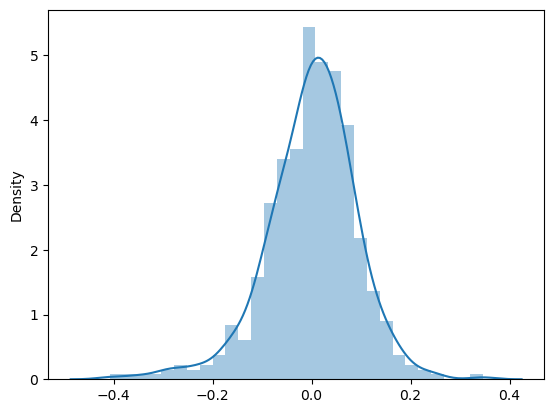

In [60]:
sns.distplot((y_train-y_train_pred))  #plotting error distribution, error = actual value - predicted value
plt.show()

Note: the errors are normally distributed

#### Assumption 2- Error Terms are Independent of each other

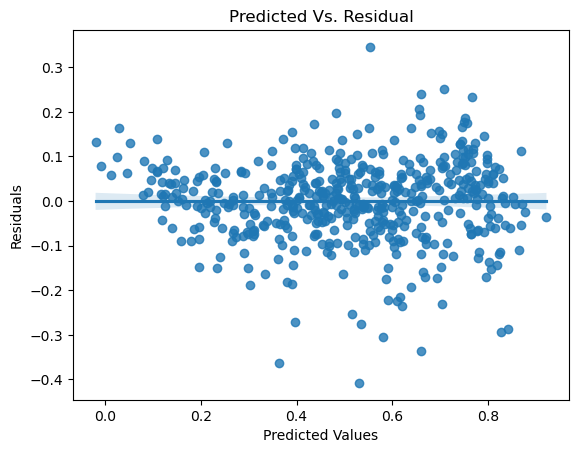

In [61]:
sns.regplot(x=y_train_pred,y=(y_train-y_train_pred))   # plotting predicted vs residual values
plt.title('Predicted Vs. Residual')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [62]:
pearsonr(y_train_pred,(y_train-y_train_pred))[0]    #calculating pearson r coefficient to check the strenght of correlation

-1.9463597400459776e-15

From graph and pearson r coeff (almost 0), it is evident that the error terms are independent of each other.

#### Assumption 3- the error terms have constant variances

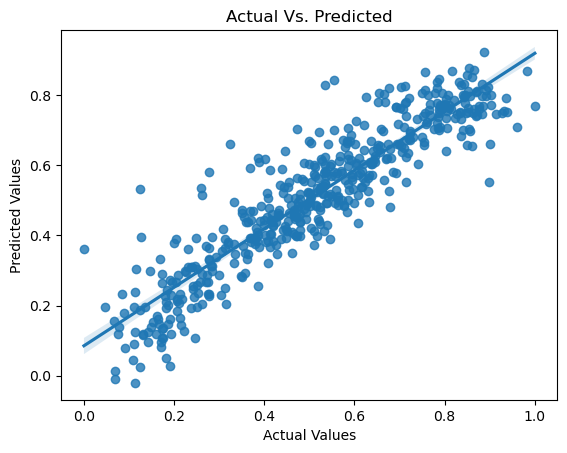

In [63]:
sns.regplot(x=y_train,y=y_train_pred)
plt.title('Actual Vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

We can observe that the points are equally distributed and not concentrated in any region. We can safely say that all the assumptions of linear regression hold true

## 6. Prediction on Test Dataset using final model.

In [64]:
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,...,mnth_Nov,mnth_Dec,weekday_Monday,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,weekday_Saturday,weathersit_2,weathersit_3
184,0,1,0,29.793347,63.7917,5.459106,6043,0,1,0,...,0,0,0,0,1,0,0,0,1,0
535,1,0,1,32.082500,59.2083,7.625404,6211,1,0,0,...,0,0,0,0,0,1,0,0,0,0
299,0,0,0,19.270000,81.2917,13.250121,2659,0,0,1,...,0,0,0,0,0,0,0,1,1,0
221,0,0,1,31.433347,42.4167,13.417286,4780,0,1,0,...,0,0,0,0,0,0,1,0,0,0
152,0,0,0,29.315000,30.5000,19.583229,4968,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [65]:
df_test[num_cols] = scalar.transform(df_test[num_cols]) # transforming test dataset wrt scale of train dataset

In [66]:
df_test.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,...,mnth_Nov,mnth_Dec,weekday_Monday,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,weekday_Saturday,weathersit_2,weathersit_3
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.640909,0.558718,0.551340,0.313293,0.522154,0.263636,0.245455,0.236364,...,0.072727,0.086364,0.118182,0.122727,0.159091,0.140909,0.131818,0.172727,0.318182,0.027273
std,0.500809,0.187620,0.480828,0.233187,0.184403,0.159584,0.219163,0.441609,0.431338,0.425817,...,0.260281,0.281541,0.323559,0.328872,0.366595,0.348721,0.339064,0.378873,0.466833,0.163248
min,0.000000,0.000000,0.000000,0.046591,0.084665,-0.042808,0.048205,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.355429,0.416134,0.198843,0.378595,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558172,0.535676,0.300126,0.524678,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.755981,0.682271,0.402718,0.677750,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,0.984424,1.002662,0.807474,0.963300,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
y_test = df_test.pop("cnt")
X_test = df_test

In [68]:
X_test = X_test[required_cols]
X_test_sm = sm.add_constant(X_test)

In [69]:
y_test_pred = lm6_model.predict(X_test_sm)

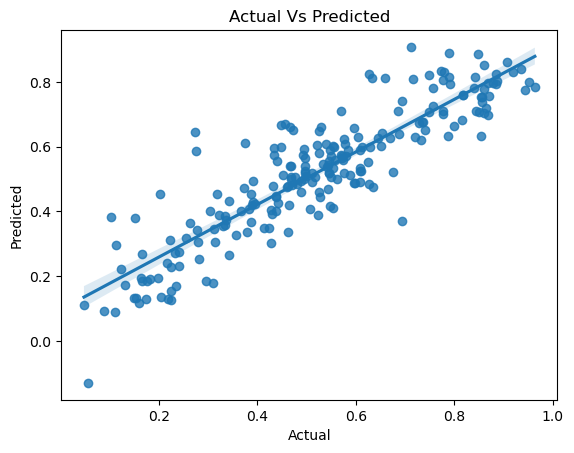

In [70]:
sns.regplot(x=y_test,y=y_test_pred)
plt.title("Actual Vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

- We can see that the model is performing quite well even on test data set

#### R2 score of test dataset

In [71]:
r2_test = r2_score(y_true=y_test,y_pred=y_test_pred)
r2_test

0.7935224695104378

#### Difference between R2 score of Train and Test dataset

In [72]:
diff_r2 = (lm6_model.rsquared - 0.7935)*100
diff_r2

4.036062441209076

#### Adjusted R2 score of test dataset

In [73]:
N = X_test.shape[0] 
p = X_test.shape[1]
adj_r2_test = 1 - ((1-r2_test)*(N-1)/(N-p-1))
adj_r2_test

0.7836431618315114

#### Difference between Adjusted R2 score of Train and Test dataset

In [74]:
diff_adj_r2 = (lm6_model.rsquared_adj - adj_r2_test)*100
diff_adj_r2

4.688801617601202

#### Mean Squared Error

In [75]:
mse = MSE(y_test, y_test_pred)
print('Mean_Squared_Error :' ,round(mse,4))

Mean_Squared_Error : 0.0099


In [76]:
print(f"R2 score for training dataset is 0.834")
print(f"R2 score for test dataset is {round(r2_test,4)} \n")
print(f"Adjusted R2 score for training dataset is 0.831")
print(f"Adjusted R2 score for test dataset is {round(adj_r2_test,4)}\n")
print(f"Difference in R2 score is {round(diff_r2,2)}")
print(f"Difference in Adjusted R2 score is {round(diff_adj_r2,2)}\n")
print(f"Mean Squared Error is : {round(mse,4)}")

R2 score for training dataset is 0.834
R2 score for test dataset is 0.7935 

Adjusted R2 score for training dataset is 0.831
Adjusted R2 score for test dataset is 0.7836

Difference in R2 score is 4.04
Difference in Adjusted R2 score is 4.69

Mean Squared Error is : 0.0099


#### Final Equation for the best fit line - Relationship between target and predictors

In [77]:
# cnt =( 0.130722 + 0.232563* yr - 0.096575* holiday + 0.517336* temp -0.149709* windspeed + 0.101217* season_summer
#        + 0.137090* season_winter + 0.054141* mnth_Aug + 0.116291* mnth_Sep 
#        - 0.081139*weathersit_2-0.281852*weathersit_3 )

### Interpretation of above equation

- 1) year: year and count shows positive relation with count variable, which means the demand is going to rise over the coming years, although this result may be biased as we only had dataset of 2 years which was following the same trend.
- 2) holiday : holiday showed negative relation with count, as per our equation, on holiday the rental count would dip by 0.096575 units.
- 3) temperature - with unit increase in temp the count will increase by 0.517336. As the data had max temp 35° C, this interpretation might hold true till temp in the vicinity of 35° C only.  
- 4) windspeed : windspeed and count shows negative relation. For a unit increase in wind speed the rental count would decrease by 0.149709.
- 5) season_summer,season_winter: Both the seasons shows positive relation with the count.
- 6) mnth_Aug,mnth_Sep: In month of aug, sept the demand for rental would increase.
- 7) weathersit_2, weathersit_3: For a unit increase in weather situation 2, the count will decrease by 0.081139 and For a unit increase in weather situation 3, the count will decrease by 0.281852

### Conclusion and Recommendations

- 1) Temperature - With increase in temp the rental count would also increase, as a good gesture, company can provide free coupon for a complimentary cold drink with the rental ride, which customers can reedem on specific stores where company has done tie ups with. Although this might seem insignificant but will definitly lead to positive word of mouth publicity and ultimately increase the awarness about the rental service.
- 2) holiday : Either company can provide some discount offers on holiday to increase the rental count or hike the rental price by some margine in order to compensate the revenue lost by dip in rental count. Company will have to implement both of these strategies and closely observe the repurcussions on rental count. Also, the price hike should be gradual or else it might hurt the sentiments of customers.
- 3) windspeed : Boombike company can improve the existing design of bikes by focusing more on aerodynamics to counter the windspeeds and include this as an additional safety measure while doing marketing and promotion in order to increase awarness among customers. 
- 4) season_summer,season_winter: as we know in summer and winter the demand is going to rise, we can deploy more bikes to reduce the waiting time of customers (if applicable) in high demand areas during peak hours.
- 5) mnth_Aug,mnth_Sep: In month of aug, sept the demand for rental would increase. to capitalise this opportunity we can organise some special campaigns in the month of may and june to enroll more customers as registered members.
- 6) weathersit_2, weathersit_3: As we know, the demand is going to decrease in these weather situations, company can provide some discount coupons to encourage new customers to try out our service.